In [1]:
#!bin/usr/python3
PATH = 'F:/WorkSpaces/Learning/[DataHack] Loan Prediction/Data/'
TRAIN_DATA = PATH + 'train_ctrUa4K.csv'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [3]:
# load train data
df = pd.read_csv(TRAIN_DATA)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# total data
df.shape

(614, 13)

In [5]:
# get description of numerical variables/columns from the dataset
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


There are total 614 values (rows) with 13 features (column).

Only numerical variables are described using this function.

Any column's count less than 614 represents "missing".

- LoanAmmount: there are $\displaystyle\frac{614 - 592}{614}\approx3.5\%$ missing values


- Loan_Amount_Term: there are $2.3\%$ missing values


- Credit_History: there are $8.1\%$ missing values

Around $84\%$ people have Credit_History (From mean).

- 1.0 means Yes and 0.0 means No. 

# I. Identify the pattern
#### 1. Correlation vs Causation
Since to make a rough guess on which variables may have huge impact on the Loan Decision. I consider the Correlation between __Loan_Status__ with other variables. However, the Correlation is not neccessarily the Causation, and since I dont have any tool to evaluate Causation directly, I go through the Correlation to make a guess about the Causation. 

Another thing needs to bear in mind is that outliers have impact on Correlation. Since I havent treated the outliers yet, the result here may even be less accurated.

The rough guess here will help me form a very first "flow" of my analysis, i.e, which variables I should treat with care or which feature may have the most influence to Loan Decision.

##### Caution: Correlation and Causation are different things !!!!! And there is no certain conclusion about causation through Correlation, use this way of thinking cautiously.

In [6]:
# get frequency of non-numerical columns
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [7]:
# Map non-numerical values into numerical values so we can compute correlation
map_YN = {'Y' : 1, 'N' : 0}
map_YN1 = {'Yes' : 1, 'No' : 0}
map_Gender = {'Male' : 1, 'Female' : 0}
map_Edu = {'Graduate' : 1, 'Not Graduate' : 0}
map_Area = {'Urban' : 0, 'Rural' : 1, 'Semiurban' : 2}
df_mapped = df.replace({'Loan_Status' : map_YN,
                        'Married' : map_YN1, 
                        'Self_Employed' : map_YN1,
                        'Gender' : map_Gender,
                        'Education' : map_Edu,
                        'Property_Area' : map_Area})
df_mapped.head()
df_mapped.corr()['Loan_Status'] # The correlation between Loan_Status and other variables

Gender               0.019857
Married              0.089280
Education            0.085884
Self_Employed       -0.002303
ApplicantIncome     -0.004710
CoapplicantIncome   -0.059187
LoanAmount          -0.037318
Loan_Amount_Term    -0.021268
Credit_History       0.561678
Property_Area        0.103253
Loan_Status          1.000000
Name: Loan_Status, dtype: float64

#### 2. Forming the "flow" of my analysis
By observation, It can be seen that Credit_History __may__ have high influence to the Loan_Status, since it stands out too much as compared to the rest. I will then use Pivotal Table to have further anlysis on the relationship between __Credit_History__ and __Loan_Status__

In [8]:
# Try finding the Trend between Credit_History vs Loan_Status
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status', index=['Credit_History'], aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print ('Frequency Table for Credit History: \n%s' % temp1) 
print ('\nProbility of getting loan for each Credit History class: \n%s' % temp2)

Frequency Table for Credit History: 
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probility of getting loan for each Credit History class: 
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


Let's plot the bar charts to make comparision easier.

[Text(0, 0, 'No'), Text(0, 0, 'Yes')]

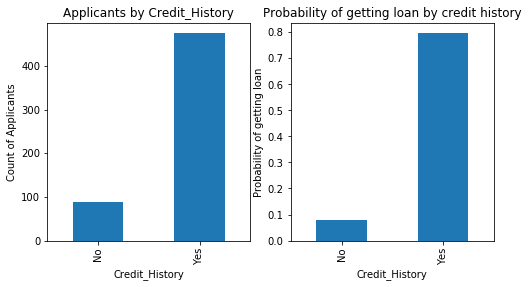

In [9]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar', ax=ax1)
ax1.set_xticklabels(['No', 'Yes'])

ax2 = fig.add_subplot(122)
ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history")
temp2.plot(kind = 'bar', ax=ax2, legend=False)
ax2.set_xticklabels(['No', 'Yes'])

It seems that having a credit_history will likely to get a loan as well. Still, the pattern above only tells us the correlation between the credit_history and probability of getting loan, however from this I can say the learning algorithm will bias to this Credit_History and I can actually just build a learning algorithm based on __Credit_History__ only. However, I still want to build learning model based on another variables for this problem.

# II. Data Wrangling
#### 1. Mean and Std
I will assumed that all variables follow normal distribution, so I can use the idea of __Z-score__ to detect outliers.

From Mean and Std of the table above, I can roughly guess where should be the center of distribution of a variable.

then I evaluate which variable has "outliers" needed to be treated by roughly calculate the $outlier_{thershold} = mean + 3 \times std$. (Derived from the __Z-score__ formular)

"Missing Values" and "Outliers" in variables are required some amount of data wrangling.

Since this project is for the sake of learning, it is good to test various learning algorithms from linear/logistic regression, tree-based model to neural networks. And because Logistic regression are sensity to missing values and outliers, I need to treat these two. 

Basically to recognise which variables has outliers, let us consider their boxplots.

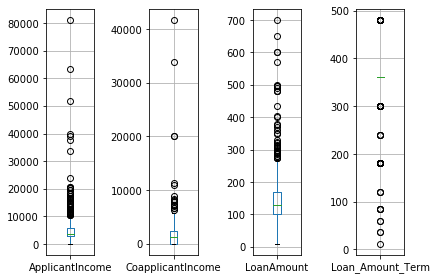

In [10]:
plt.subplot(1,4,1)
df.boxplot(column='ApplicantIncome')
plt.subplot(1,4,2)
df.boxplot(column='CoapplicantIncome')
plt.subplot(1,4,3)
df.boxplot(column='LoanAmount')
plt.subplot(1,4,4)
df.boxplot(column='Loan_Amount_Term')
plt.tight_layout()

Loan_Amount_Term has no outliers based on its boxplot.

The other three need treatment.

Next to recognise which variables have missing values:

In [11]:
df.apply(lambda x: sum(x.isnull()), axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

The amount of missing is not much comparing the total rows (614). There is not neccessary to drop a whole column, however these missing values need to be filled somehow.

One note, sometimes 'NaN' or 'None' are not the only indicators of "missing values", it really depends on the meaning of the variables. In this case, if numerical variables like __ApplicantIncome__, __Loan-Amount-Term__, listed above, contain some __0__ , it makes more sense considering those __0__ as missing values rather than meaningful figures. 

In [12]:
df.apply(lambda x: sum((x==0).astype(int)), axis=0) 

Loan_ID                0
Gender                 0
Married                0
Dependents             0
Education              0
Self_Employed          0
ApplicantIncome        0
CoapplicantIncome    273
LoanAmount             0
Loan_Amount_Term       0
Credit_History        89
Property_Area          0
Loan_Status            0
dtype: int64

It seems that there is no nonsense zeroes here.

#### 2. Treatment

#### a. ApplicantIncome Variables
In ApplicantIncome, the center should be around $5403 \pm 6109$. Anything greater than $5403 + 3*6109 = 23730$ is considered to be outliers. If I plot the distribution of this variable, I expect to see a large amount of sample in the range $ [0, 11512]$.

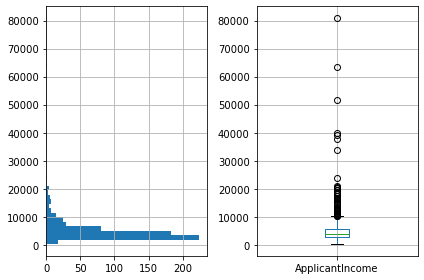

In [13]:
# plot the histogram and box_plot of the ApplicantIncome
plt.subplot(1,2,1)
df['ApplicantIncome'].hist(bins=50, orientation='horizontal') # 50 bins are sufficient to describe clearly the distribution
plt.subplot(1,2,2)
df.boxplot(column='ApplicantIncome')
plt.tight_layout()

In [14]:
df['Education'].value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

The histogram on the left tells me the distribution of the __ApplicantIncome__ variable. The box_plot on the right is to point out the outliers in a clearer way. 

I attempt to explain the reasons behind the outliers of the ApplicantIncome. In this dataset, the factor that may have signigficant influence to the Income is the __Education__. Specifically, Is it possible that that __graduate__ may have higher income that __not graduate__ ?

To clarify this, lets group the Income by Education and see their box_plot

Text(0.5, 1.05, 'Boxplot by Education')

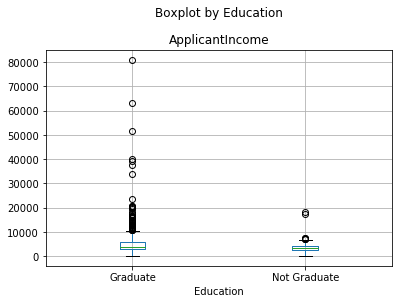

In [15]:
df.boxplot(column='ApplicantIncome', by = 'Education')
plt.suptitle('Boxplot by Education', y=1.05)

The means of income are pretty similar for both __Graduate__ and __Not Graduate__ Applicants. But the outliers are all in  __Graduate__ group, which confirmed my hypothesis above.

#### Combine both ApplicantIncome and CoapplicantIncome

However, I notice that, there are two types of Income here, and from the boxplots above, both of them contain outliers. It is not a good idea to treat their outliers independently, because they are additictive to each other. In fact, I should only consider the Sum Income from both of them. Thus I wont miss the case that is only one of them has good income is sufficient to affect the Loan Decision.

In [16]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

Let's try nullify the impact of outlier by applying log scale to the TotalIncome.

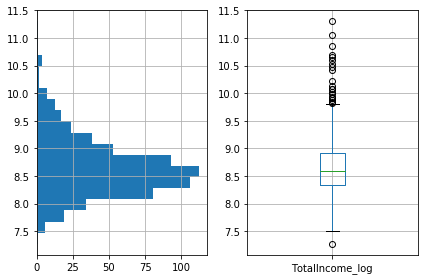

In [17]:
plt.subplot(1,2,1)
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['TotalIncome_log'].hist(bins=20, orientation='horizontal') 
plt.subplot(1,2,2)
df.boxplot('TotalIncome_log')
plt.tight_layout()

The distribution of TotalIncome_log (right figure) looks closer to the normal distribution

In [18]:
# the outlier threshold for this variable is calculated as followed:
df['TotalIncome_log'].mean() + 3*df['TotalIncome_log'].std()

10.304718173059907

From the boxplot of TotalIncome_log, I can see that the outliers become less impactful than the orignal one (closer to the the outlier threshold = 10.3) and since there are not so many outliers, I dont need to drop them but use the log scale version of this variable instead.

#### b. LoanAmount Variable
Next, moving on to the __LoanAmount__.

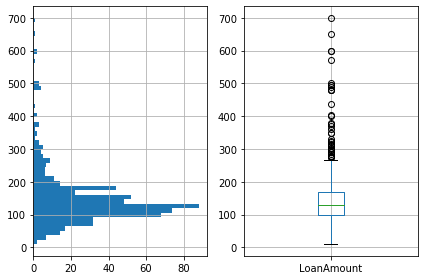

In [19]:
plt.subplot(1,2,1)
df['LoanAmount'].hist(bins=50, orientation="horizontal") # 50 bins are sufficient to describe clearly the distribution
plt.subplot(1,2,2)
df.boxplot(column='LoanAmount')
plt.tight_layout()

Text(0.5, 1.05, 'Boxplot by Education')

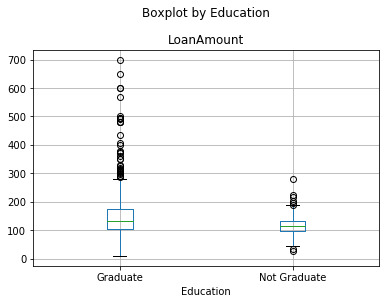

In [20]:
df.boxplot(column='LoanAmount', by = 'Education')
plt.suptitle('Boxplot by Education', y=1.05)

This variable has "missing values" and "outliers" need to be treated. And it appears to me that the the outliers comes mostly from "Graduate" group.

#### Treating missing values

The easiest way is to just fill the missing values with means.

df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
 
However, for the sake of learning, lets do it differently, by filling in missing values base on the basis of other variables (__unit imputation__). I will use multivariate linear regression model for imputation.

In [21]:
map_YN = {'Y' : 1, 'N' : 0}
map_YN1 = {'Yes' : 1, 'No' : 0}
map_Gender = {'Male' : 1, 'Female' : 0}
map_Edu = {'Graduate' : 1, 'Not Graduate' : 0}
map_Area = {'Urban' : 0, 'Rural' : 1, 'Semiurban' : 2}
df_mapped = df.replace({'Loan_Status' : map_YN,
                        'Married' : map_YN,
                        'Self_Employed' : map_YN1,
                        'Gender' : map_Gender,
                        'Education' : map_Edu,
                        'Property_Area' : map_Area})
df_mapped.head()
df_mapped.corr()['LoanAmount']

Gender               0.106947
Education            0.171133
Self_Employed        0.123931
ApplicantIncome      0.570909
CoapplicantIncome    0.188619
LoanAmount           1.000000
Loan_Amount_Term     0.039447
Credit_History      -0.008433
Property_Area        0.014074
Loan_Status         -0.037318
TotalIncome          0.624621
TotalIncome_log      0.700809
Name: LoanAmount, dtype: float64

From the above correlation tables and from our common sense, The missing values in __LoanAmount__ can be estimated based on __Education__ , __Self_Employed__ and __TotalIncome_log__. And thus my linear regression model to fill the __LoanAmount__ will take __Education__ , __Self_Employed__ and __TotalIncome_log__ as inputs. 

I must make sure all the referal variables are free of missing values.

In [22]:
df.apply(lambda x: sum(x.isnull()), axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
TotalIncome           0
TotalIncome_log       0
dtype: int64

So only __Self_Employed__ variable has 32 missing values and it is a non-numerical variable. To fill the missing value for __Self_Employed__ there are numerous ways:

- based on the frequency of other values in the variables
- based on another variable, we repeat the step above, check correlation table and the intuition.

In this case, I believe the first approach is sufficient.

In [23]:
# check frequency of values in Self_Employed
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

Majority of values are No, lets just simply assign No to all NaN values.

In [24]:
df['Self_Employed'].fillna('No',inplace=True)

Now I can build multivariate linear regression model to fill the __LoanAmount__

In [25]:
# re-mapped
df['Self_Employed'].fillna('No', inplace=True)
map_YN = {'Y' : 1.0, 'N' : 0.0}
map_YN1 = {'Yes' : 1.0, 'No' : 0.0}
map_Gender = {'Male' : 1.0, 'Female' : 0.0}
map_Edu = {'Graduate' : 1.0, 'Not Graduate' : 0.0}
map_Area = {'Urban' : 0.0, 'Rural' : 1.0, 'Semiurban' : 2.0}
df_mapped = df.replace({'Loan_Status' : map_YN,
                        'Married' : map_YN1,
                        'Self_Employed' : map_YN1,
                        'Gender' : map_Gender,
                        'Education' : map_Edu,
                        'Property_Area' : map_Area})

#### Note:
Before continue, let me explain a bit about my mapping above. You may notice i remapped categorical variables into numerical variable. I mapped three categories of __Property_Area__ into __ordered numerical values__ (1,2,3). This is not allowed if I use this variable for learning model. But since I just want to have a rough test with correlation (I actually tried different combination of numbers, the correlation doest not change much) to figure out which variable is possibly the important one here, I can temporarily ignore this way of __ordered mapping__. A solution for this is to split this variable into __2 dummy varibles__.

In [26]:
# create three dummy variables using get_dummies
pd.get_dummies(df['Property_Area'], prefix='Area').head()

,Area_Rural,Area_Semiurban,Area_Urban
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


However, I actually only need two dummy variables, not three because 2 dummies are enough to capture the information of the original variable.

In [27]:
# create three dummy variables using get_dummies, then exclude the second dummy column
area_dummies = pd.get_dummies(df['Property_Area'], prefix='Area').iloc[:, [0,2]]
area_dummies.head()

,Area_Rural,Area_Urban
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1


__rural__ is coded as Area_Urban=0 and Area_Rural=1

__urban__ is coded as Area_Urban=1 and Area_Rural=0

__suburban__ is coded as Area_Urban=0 and Area_Rural=0

Now, I will get back to the treatment of missing values in LoanAmount. 

#### Implementation of multivariate linear regression

In [28]:
# get all the indexes of missing values from LoanAmount
Missing_index = df_mapped['LoanAmount'][df_mapped['LoanAmount'].isnull()].index

# training output
Output_loan = df_mapped['LoanAmount'].dropna(axis = 0, how ='any', inplace=False)

# training input
Features = pd.DataFrame(df_mapped[['TotalIncome_log','Self_Employed','Education']])

In [29]:
Features.drop(Missing_index, axis=0, inplace=True)
Features.values

array([[8.71456755, 0.        , 1.        ],
       [8.00636757, 1.        , 1.        ],
       [8.50532302, 0.        , 0.        ],
       ...,
       [9.02545553, 0.        , 1.        ],
       [8.93366418, 0.        , 1.        ],
       [8.43010908, 1.        , 1.        ]])

In [30]:
# Features.drop(Missing_index, axis=0, inplace=True)
Features.shape

(592, 3)

In [31]:
# Implementation of multivariate linear regression using tensorflow

# input/output
x = Features.values
y = Output_loan.values

# linear regression model
X = tf.placeholder(tf.float32, shape=[3,]) # 3 features/columns
Y = tf.placeholder(tf.float32) 
W = tf.Variable(tf.zeros([1,3]), name = "W") 
b = tf.Variable(tf.zeros([1]), name = "b") 

learning_rate = 0.001
training_epochs = 1000 # To overfitting this training.

# Hypothesis 
y_pred = tf.add(tf.multiply(W, X), b) 
  
# Mean Squared Error Cost Function 
cost = tf.reduce_sum(tf.pow(y_pred-Y, 2)) / (2 * len(y)) 
  
# Gradient Descent Optimizer 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) 
  
# Global Variables Initializer 
init = tf.global_variables_initializer() 

In [32]:
%%time
# set random seed to obtain same result every run
np.random.seed(101) 
tf.set_random_seed(101)

# Starting the Tensorflow Session 
with tf.Session() as sess: 
      
    # Initializing the Variables 
    sess.run(init) 
      
    # Iterating through all the epochs 
    for epoch in range(training_epochs): 
          
        # Feeding each data point into the optimizer using Feed Dictionary 
        for (_x, _y) in zip(x, y): 
            sess.run(optimizer, feed_dict={X : _x, Y : _y}) 
          
        # Displaying the result after every 100 epochs 
        if (epoch + 1) % 100 == 0: 
            # Calculating the cost a every epoch 
            c = sess.run(cost, feed_dict={X : _x, Y : _y}) 
            print("Epoch", (epoch + 1), ": cost =", c, "W =", sess.run(W), "b =", sess.run(b)) 
      
    # Storing necessary values to be used outside the Session 
    training_cost = sess.run(cost, feed_dict={X : _x, Y : _y}) 
    weight = sess.run(W) 
    bias = sess.run(b) 

Epoch 100 : cost = 16.975714 W = [[14.474614   2.0827544 10.503593 ]] b = [27.207111]
Epoch 200 : cost = 9.729788 W = [[12.116888  3.836756 18.499971]] b = [47.178993]
Epoch 300 : cost = 5.4918184 W = [[10.235913   5.3310084 24.546314 ]] b = [63.05954]
Epoch 400 : cost = 3.068248 W = [[ 8.738148   6.6172733 29.064682 ]] b = [75.70745]
Epoch 500 : cost = 1.72758 W = [[ 7.5433135  7.7364836 32.388    ]] b = [85.79965]
Epoch 600 : cost = 1.0243918 W = [[ 6.588129  8.721037 34.777958]] b = [93.870255]
Epoch 700 : cost = 0.6891724 W = [[ 5.8225384  9.59658   36.441185 ]] b = [100.34122]
Epoch 800 : cost = 0.5603757 W = [[ 5.2070026 10.383466  37.54062  ]] b = [105.54685]
Epoch 900 : cost = 0.5423352 W = [[ 4.7104177 11.097863  38.20326  ]] b = [109.74846]
Epoch 1000 : cost = 0.5793485 W = [[ 4.308132 11.752597 38.53068 ]] b = [113.15401]
Wall time: 3min 56s


In [33]:
# Calculating the predictions 
predictions = np.matmul(x, weight.T) + bias 
print("Training cost =", training_cost, "Weight =", weight, "bias =", bias, '\n') 

Training cost = 0.5793485 Weight = [[ 4.308132 11.752597 38.53068 ]] bias = [113.15401] 



## Note:

Here I tried to overfit the above multivariate linear regression model, because I want to fill the missing values in LoanAmount in such a way that there will be as less variant as possible. Overfitting in this case turns out to be good, and I dont even need to evaluate the result with validation dataset.

In [34]:
# fill the missing values
Features = pd.DataFrame(df_mapped[['TotalIncome_log','Self_Employed','Education']])
Missing_Values = Features.iloc[Missing_index]
# predictions = np.matmul(Missing_Values.values, weight.T) + bias
prediction = lambda x: np.asscalar(np.matmul(np.matrix([x['TotalIncome_log'], x['Self_Employed'], x['Education']]), weight.T) + bias)
df_mapped['LoanAmount'].fillna(df_mapped[df_mapped['LoanAmount'].isnull()].apply(prediction, axis=1), inplace=True)

#### Treating outliers
First is to try nullify the affect of outliers by applying different scale to the dataset. We use log scale here and expect to see a distribution shape as closer to normal distribution.

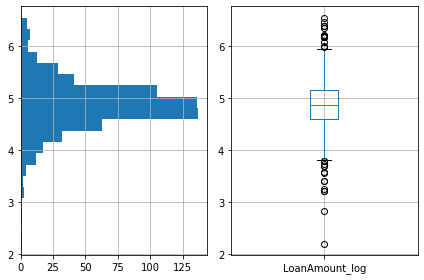

In [35]:
# log scale
plt.subplot(1,2,1)
df_mapped['LoanAmount_log'] = np.log(df_mapped['LoanAmount'])
df_mapped['LoanAmount_log'].hist(bins=20, orientation='horizontal')
plt.subplot(1,2,2)
df_mapped.boxplot(column='LoanAmount_log')
plt.tight_layout()

As expected, the outliers become less impactful, so I will use the Log transform of LoanAmount.\

Lets recheck how many variable still need a treat

df_mapped.apply(lambda x: sum(x.isnull()), axis=0)

#### 3. Treatment for Gender, Married, Dependents, Loan_Amount_term and Credit_History Variables
#### a. Gender

In [36]:
df['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

Since there is only 13 missing values, I will just assign them to Male - the dominant category here.

In [37]:
# fill Gender's missing values with Male (1.0) if there is CoapplicantIncome otherwise no (1.0)
df_mapped['Gender'].fillna(1, inplace=True)

#### b. Married

Since there is only 3 missing values, I will assumed if there is no CoapplicantIncome is given, the applicant is still single.

In [38]:
# fill Married's missing values yes (1.0) if there is CoapplicantIncome otherwise no (1.0)
df_mapped['Married'].fillna(df_mapped[df_mapped['Married'].isnull()].apply(lambda x: 1.0 if x['CoapplicantIncome'] else 0.0, axis=1), inplace=True)

#### c. Dependent

I guess this variable is number of children or retired parents live on the applicants.

In [39]:
df_mapped['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

Before filling the Missing values with 0 (this category has the highest mode/counts here), I want to try to do little analysis to see if this dependents can be imputed on the basis of other variables. Since the most relevant variables to Dependents could be LoanAmount and TotalIncome, they will be used as reference for this analysis.

In [40]:
# Treat the mixture between number and string in this variable
df_mapped.replace({'Dependents' : {'0' : 0.0, '1' : 1.0, '2' : 2.0, '3+' : 3.0}}, inplace=True)

In [41]:
# Try filling NaN with something and plot Scatter plot of Dependents based on TotalIncome_log and LoanAmount_log
include_NaN =  df_mapped[['Dependents', 'LoanAmount_log', 'TotalIncome_log', 'Property_Area']]
fill_NaN = pd.DataFrame(include_NaN)
fill_NaN['Dependents'].fillna('Missing', inplace=True)

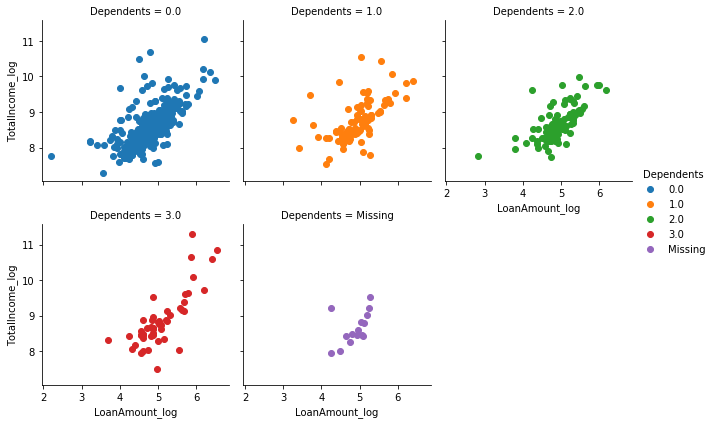

In [42]:
# Plot Scatter Plot
sns.set_stylestyle = ("whitegrid")
sns.FacetGrid(fill_NaN, col='Dependents', hue='Dependents', col_wrap=3, height=3)\
   .map(plt.scatter,"LoanAmount_log", "TotalIncome_log")\
   .add_legend()
plt.show()

Okay, it is clear to see that the missing values (Purple) lie in a common zone of other dependents categories. In this case, I will just assumed that if the Applicant didnt provide Dependents, it will mean that he or she does not have any dependents. Therefore, missing values will be filled with zeros

In [43]:
df_mapped['Dependents'].fillna(0, inplace=True)

#### d. Credit_History

This variable has been analysed before, usually if the applicant with Credit_History will get Loan. Based on this, I can fill Credit_History as __Yes__ if being loan other wise __No__

In [44]:
df_mapped['Credit_History'].fillna(df_mapped[df_mapped['Credit_History'].isnull()].apply(lambda x: 1.0 if x['Loan_Status'] else 0.0, axis=1), inplace=True)

#### e. Loan_Amount_Term     

In [45]:
df_mapped['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

I will fill the missing values with median which is more sensitive to outliers than average. 

In [46]:
df_mapped['Loan_Amount_Term'].fillna(df_mapped['Loan_Amount_Term'].median(), inplace=True)

So far I have treated all the missing_values and outliers.

In [47]:
df_mapped.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
TotalIncome          0
TotalIncome_log      0
LoanAmount_log       0
dtype: int64

#### Final Check
- Duplication of Loan_ID: ID should be unique
- One-hot encoding the Property_Area: Adding two dummy columns (mentioned before)

In [48]:
# Check if Loan_ID is dupplicated
df_mapped['Loan_ID'].duplicated().any()

False

In [49]:
df_mapped = pd.concat([df_mapped, area_dummies], axis=1)
df_mapped.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,TotalIncome_log,LoanAmount_log,Area_Rural,Area_Urban
0,LP001002,1.0,0.0,0.0,1.0,0.0,5849,0.0,189.053539,360.0,1.0,0.0,1.0,5849.0,8.674026,5.242030,0,1
1,LP001003,1.0,1.0,1.0,1.0,0.0,4583,1508.0,128.000000,360.0,1.0,1.0,0.0,6091.0,8.714568,4.852030,1,0
2,LP001005,1.0,1.0,0.0,1.0,1.0,3000,0.0,66.000000,360.0,1.0,0.0,1.0,3000.0,8.006368,4.189655,0,1
3,LP001006,1.0,1.0,0.0,0.0,0.0,2583,2358.0,120.000000,360.0,1.0,0.0,1.0,4941.0,8.505323,4.787492,0,1
4,LP001008,1.0,0.0,0.0,1.0,0.0,6000,0.0,141.000000,360.0,1.0,0.0,1.0,6000.0,8.699515,4.948760,0,1


 The dataset is now ready for building learning model. All the non-numerical values are mapped to numerical one and dummy vairiables.

# III. Learning Models

Instead of using Tensorflow to reimplement the Linear Regression, Random Forest.. models from scratch, I will use sklearn from this point onward for the sake of convenience.

The metric to evaluate the model is Cross-Validation Score (Mean of testing accuracy of every split)

In [50]:
# import Logistic Regression, Random Forest, Decision Tree, MLP Classifier(Neural Network)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import KFold
from sklearn import metrics

In [51]:
# Generic function for classification:
def classification(model, train, output):

    # Perform k-fold cross-validation with 5 folds
    kf = KFold(n_splits=5, shuffle=False)
    error = []
    
    for training_idx, validating_idx in kf.split(train):
        # Filter training data
        train_predictors = train[training_idx, :]
    
        # The target we're using to train the algorithm.
        train_target = output[training_idx]
    
        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)
    
        # Record error from each cross-validation run
        error.append(model.score(train[validating_idx, :], output[validating_idx]))

    # Fit the model:
    model.fit(train, output)

    # Make predictions on training set:
    predictions = model.predict(train)
  
    # Print accuracy
    accuracy = metrics.accuracy_score(predictions, output)
    print ("Accuracy : %.3f" % (accuracy*100))
    
    #Print Cross-Validation Score
    print ("Cross-Validation Score : %.3f" % (np.mean(error)*100))

#### 1. Logistic Regression

- First approach is to train with Credit History only, as I analysed above, this one has the highest correlation to Loan_Status. Advantage: __Avoid Overfitting__

In [52]:
df_mapped.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,TotalIncome_log,LoanAmount_log,Area_Rural,Area_Urban
0,LP001002,1.0,0.0,0.0,1.0,0.0,5849,0.0,189.053539,360.0,1.0,0.0,1.0,5849.0,8.674026,5.242030,0,1
1,LP001003,1.0,1.0,1.0,1.0,0.0,4583,1508.0,128.000000,360.0,1.0,1.0,0.0,6091.0,8.714568,4.852030,1,0
2,LP001005,1.0,1.0,0.0,1.0,1.0,3000,0.0,66.000000,360.0,1.0,0.0,1.0,3000.0,8.006368,4.189655,0,1
3,LP001006,1.0,1.0,0.0,0.0,0.0,2583,2358.0,120.000000,360.0,1.0,0.0,1.0,4941.0,8.505323,4.787492,0,1
4,LP001008,1.0,0.0,0.0,1.0,0.0,6000,0.0,141.000000,360.0,1.0,0.0,1.0,6000.0,8.699515,4.948760,0,1


In [53]:
# Case1: Train Model with only Credit_History feature
n = df_mapped.shape[0]
model = LogisticRegression(solver='lbfgs')
train = df_mapped['Credit_History'].values.reshape(n,1) # shape of X = (n, 1)
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 83.062
Cross-Validation Score : 83.065


In [54]:
# Case2: Train Model with more features exclude Credit_History
model = LogisticRegression(solver='lbfgs')
train = df_mapped[['Education', 'Married', 'Self_Employed']].values # shape of X = (n, 1)
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 68.730
Cross-Validation Score : 68.729


In [55]:
# Case3: Train Model with more features
model = LogisticRegression(solver='lbfgs')
train = df_mapped[['Credit_History', 'Education', 'Married', 'Self_Employed']].values # shape of X = (n, 1)
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 83.062
Cross-Validation Score : 83.065


From the results above:
- it is clear to see that __Credit_History__ has dominant influence to the __Loan_Status__. That is the reason why we obtained same testing accuracy and cross-validation score if there is Credit_History presence regardless to wheter or not there are other variables presence. (Case 1, Case 3)

- Without the Credit_History presence, the accuracy drops as shown in case 2.

- The accuracy is equal or slightly lower the cross-validation score, indicating there is no overfitting.

To remove the dominant influence of Credit_history, I may do feature_engineering by creating another strong features, however, this approach is pretty tough. The simpliest way is to move on with another learning algorithm.

#### 2. Decision Tree

This model is pretty easy to get overfitted. Since it takes all data into account.

In [56]:
model = DecisionTreeClassifier(random_state=0)
train = df_mapped[['Credit_History']].values # shape of X = (n, 1)
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 83.062
Cross-Validation Score : 83.065


In [57]:
[model.tree_.max_depth, model.tree_.node_count]

[1, 3]

In [58]:
model = DecisionTreeClassifier(random_state=0)
train = df_mapped[['Credit_History', 'Education', 'Married', 'Self_Employed', 'Area_Rural', 'Area_Urban']].values # shape of X = (n, 1)
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 83.062
Cross-Validation Score : 80.299


In [59]:
[model.tree_.max_depth, model.tree_.node_count]

[6, 71]

It seems the model run into overfitting if I use further variable with 'Credit_History'.

#### 3. Random Forest

Random forest is very powerful learning algorithm against imbalance datasets and vairous learning features. The dominace impact of __Credit_History__ may be resolved using this method.

In [60]:
model = RandomForestClassifier(n_estimators = 100, max_depth = None, random_state = 1)
train = df_mapped[['Gender', 'Married', 'Dependents', 'Education',
                   'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Area_Rural', 'Area_Urban',
                   'LoanAmount_log','TotalIncome_log']].values
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 100.000
Cross-Validation Score : 80.625


This model is absolutely overfitting, the training accuracy reaches 100%.

I will play around with the trees and depths a bit.

In [61]:
model = RandomForestClassifier(n_estimators = 10, max_depth = 4, random_state = 1)
train = df_mapped[['Gender', 'Married', 'Dependents', 'Education',
                   'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Area_Rural', 'Area_Urban',
                   'LoanAmount_log','TotalIncome_log']].values
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 84.039
Cross-Validation Score : 80.119


Generally speaking, it is much better than before, the Training Accuracy is not higher than The Score too much.

I want to see how RandomForest "weighted" the importance of each features.

In [62]:
# Print features in descending order of their weights
labels = ['Gender', 'Married', 'Dependents', 'Education',
          'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Area_Rural', 'Area_Urban',
          'LoanAmount_log','TotalIncome_log']
for feature in sorted(zip(labels, model.feature_importances_), key = lambda x: x[1]):
    print(feature)

('Self_Employed', 0.009442531028655258)
('Gender', 0.01240098717964853)
('Married', 0.019520277034062408)
('Area_Urban', 0.02014729913172134)
('Area_Rural', 0.03743132091192695)
('Dependents', 0.04115072640403719)
('Education', 0.042277920099964755)
('Loan_Amount_Term', 0.05135824519303976)
('LoanAmount_log', 0.07886503052384204)
('TotalIncome_log', 0.22725585127126136)
('Credit_History', 0.4601498112218405)


I will retrain the model with features has weights greater than 0.04. They are __LoanAmount_log, TotalIncome_log, Credit_History__ .

In [63]:
model = RandomForestClassifier(n_estimators = 10, max_depth = 4, random_state = 1)
train = df_mapped[['Credit_History', 'LoanAmount_log', 'TotalIncome_log']].values
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 83.876
Cross-Validation Score : 82.252


We can see the Cross-Validation Score improved a bit and the testing accuracy decreases which is a good sign in this case, because that means the model's behaviour is generraly good. 

Some conclusion:
- Training with only importance feature actually improves the model
- Credit History is still a dominant variable
- I should do some research about __Loan__ and find out if I can find  dominant factor(s) beyond Credit_History to do featuring engineering, however it is out of scope for this learning.

#### 4. Neural Network

So far I have used Logistic Regression, Decision Tree, Random Forest and the results obtained were not so satisfied. Generaly speaking, their performance are on pair with each others. I will try Neural Network to see if there is any huge improvemence.

I will use sklearn to form my neural network instead of creating from scratch using Tensorflow

In [64]:
# with 1 layer - 22 neurons
learning_rate = 1e-5
model = MLPClassifier(solver='adam', activation='relu', alpha=learning_rate,
                      hidden_layer_sizes=(22), max_iter=1000, random_state=1)
train = df_mapped[['Gender', 'Married', 'Dependents', 'Education',
                   'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 
                   'Area_Rural', 'Area_Urban', 'LoanAmount_log', 'TotalIncome_log']].values
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 81.107
Cross-Validation Score : 76.556


In [65]:
# with 2 layers - (22, 5) neurons
learning_rate = 1e-5
model = MLPClassifier(solver='adam', activation='relu', alpha=learning_rate,
                      hidden_layer_sizes=(22, 5), max_iter=1000, random_state=1)
train = df_mapped[['Gender', 'Married', 'Dependents', 'Education',
                   'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 
                   'Area_Rural', 'Area_Urban', 'LoanAmount_log', 'TotalIncome_log']].values
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 68.730
Cross-Validation Score : 79.807


In [66]:
# with 2 layers - (22, 10, 5) neurons
learning_rate = 1e-5
model = MLPClassifier(solver='adam', activation='relu', alpha=learning_rate,
                      hidden_layer_sizes=(25, 10, 5), max_iter=5000, random_state=1)
train = df_mapped[['Gender', 'Married', 'Dependents', 'Education',
                   'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 
                   'Area_Rural', 'Area_Urban', 'LoanAmount_log', 'TotalIncome_log']].values
output = df_mapped['Loan_Status'].values # shape of Y = (n, ?)
classification(model, train, output)

Accuracy : 75.570
Cross-Validation Score : 77.858


It seems this approach very promising, but it more or less like a loterry game. Like with just 1 hidden layer of 22 neurons, the result is already pretty good. 

I may find a better solution if I play around with numbers a little longer. 

Conclusion:
- Moving from Linear Regression to Random Forest and eventually to Neural Network. We lose the __linearity__ however the performance may become better. 
- It is very hard to explain what is actually happening inside the Neural Network... especially as deeper the network is as less intuative for understanding how it came up with the results. This is the __biggest limitation__ of Neural Network over the other two learning algorithms.
- I prefer using Tensorflow to code everything scratch as I have more control on what I am doing such as I can play around with any parameters I like, tuning optimizer, choose different resolution on printing training accuracy. Scikit learn although is very convenient, it lacks the control I need.
- One important thing I learn, featuring engineer is actually important, but it requires some knowledge on the field I am working on. 